# Расчётно-графическая работа №1
## Студент группы КА-03мп
## Соболь Артур

### Импортируем необходимые библиотеки

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math
import statsmodels.api as sm
from datetime import datetime
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from scipy.signal import dlti, dlsim, unit_impulse
from scipy.linalg import norm
import typing as tp
from itertools import combinations
import numpy as np
from scipy.signal import convolve
from scipy.linalg import eig, inv, svd, block_diag, solve, pinv
from numba import njit

In [3]:
np.set_printoptions(precision=2)
RS = RandomState(MT19937(SeedSequence(int(datetime.now().timestamp()*1e5))))

### Сначала необходимо разработать класс, который будет иметь возможность генерировать данные, симулировать системный отклик, трансформировать данные в формы, необходимые для определённых моделей и возвращать параметры этих моделей.

In [4]:
class LDS():
    """
    Linear Dynamical System
    -----------------------
    Generates data
    """
    def __init__(self, n_real: int, n_im: int, mode: str = 'observed'):
        """
        Constructor method
        ------------------
        :param n: size of system
        :type n: int
        """
        self.n = 2*n_im + n_real
        self.p_im = n_im
        self.p_real = n_real
        if mode not in ['control', 'observed']:
            raise ValueError('mode must be strictly `conrol` or `observed`')
        self._construct_params(mode)
    
    def _construct_params(self, mode: str) -> None:
        """
        Calculate System Parameters
        ---------------------------
        :param mode: mode of system
        """
        omega_im = [np.random.default_rng().uniform(low=0., high=np.pi/8)
                        for _ in range(self.p_im)]
        self.alpha_im = [np.random.default_rng().uniform(low=0.9, high=np.cos(omega))
                        for omega in omega_im]
        min_omega = np.argmin(omega_im) if omega_im else None
        ro_min = self.alpha_im[min_omega]/np.cos(omega_im[min_omega]) if min_omega else 0.93
        ro_real = [np.round(np.random.default_rng().uniform(low=ro_min, high=1.),4)
                        for _ in range(self.p_real)]
        ro_im = [np.round(alpha/np.cos(omega),4) for alpha, omega in zip(self.alpha_im, omega_im)]
        self.beta_im = [np.sqrt(ro**2-alpha**2) for ro, alpha in zip(ro_im, self.alpha_im)]
        self.ro = ro_real + ro_im
        self.omega = [0. for _ in range(self.p_real)] + omega_im
        self.f_s = [0. for _ in range(self.p_real)] +\
            [np.random.default_rng().uniform(low=0.5, high=1.)*np.random.default_rng().choice([-1., 1])
            for _ in range(self.p_im)]
        self.f_c = [np.random.default_rng().uniform(low=0.5, high=1.)*np.random.default_rng().choice([-1., 1])
            for _ in range(self.p_real+self.p_im)]
        if mode == 'observed':
            self.c_s = [0. for _ in range(self.p_real+self.p_im)]
            self.c_c = [1. for _ in range(self.p_real+self.p_im)]
            self.b_s = self.f_s
            self.b_c = self.f_c
        else:
            self.b_s = [0. for _ in range(self.p_real+self.p_im)]
            self.b_c = [1. for _ in range(self.p_real+self.p_im)]
            self.c_s = list(map(lambda x: -x, self.f_s))
            self.c_c = self.f_c
        
    
    def simulate(self, T: int, signal: np.ndarray) -> tp.List[float]:
        """
        Simulates system response
        -------------------------
        """
        outputs = [sum([ro**(i)*(fc*np.cos(omega*i)+fs*np.sin(omega*i)) 
                    for (ro, fc, fs, omega) in zip(self.ro, self.f_c, self.f_s, self.omega)])
                    for i in range(T+1)]
        return np.append([0.], convolve(outputs, signal))[:T]


    def transform_params(self) -> tp.List[np.ndarray]:
        """
        Trasforms System params to State-Space and ARMA params
        ------------------------------------------------------
        """
        eigv = np.append(self.ro[:self.p_real], 
                    np.array([[a+b*1j, 1j*(-b)+a] for a, b in zip(self.alpha_im, self.beta_im)]).flatten())
        indexes = range(self.n)
        ai = [(-1)**i*np.sum([np.prod(eigv[list(idxs)]) for idxs in combinations(indexes, i+1)])
                for i in indexes]
        A = np.eye(len(eigv), k=-1)
        A[:, -1] = np.array(ai[::-1]).T
        C = np.append(np.zeros(self.n-1), [1.])
        G_LHS = np.array([C@np.linalg.matrix_power(A, i) for i in range(len(A))])
        G_RHS_REAL = [np.power(np.array(self.ro[:self.p_real]), i).tolist() for i in range(self.n)]
        G_RHS_IM = [sum([np.linalg.matrix_power([[a, b], [-b, a]], i)[0].tolist()
                    for (a,b) in zip(self.alpha_im, self.beta_im)], []) 
                    for i in range(self.n)]
        T = np.linalg.solve(G_LHS, np.hstack((G_RHS_REAL, G_RHS_IM)))
        B_RHS = sum([[fc] if fs == 0. else [fc, fs] for fc, fs in zip(self.f_c, self.f_s)], [])
        B = T@B_RHS
        return A, B, C
    
    def get_statespace(self) -> tp.List[np.ndarray]:
        """
        Returns params for State-Space Form
        -----------------------------------
        """
        A, B, C = self.transform_params()
        return A, B.reshape(-1,1), C.reshape(1,-1), [[0.]]
    
    def get_arma(self) -> tp.List[np.ndarray]:
        """
        Returns params for ARMA Form
        -----------------------------------
        """
        A, B, _ = self.transform_params()
        A = np.r_[1, -A[:, -1][::-1].ravel()]
        B = np.r_[0, B[::-1]]
        return A, B


### Разработаем две вспомогательные функции для визуализирования матрицы и построения графика сигнала. 

In [5]:
def bmatrix(a: np.ndarray, name: str) -> str:
    if len(a.shape) > 2:
        raise ValueError('Only 2 dim')
        
    lines = str(np.round(a, 3)).replace('[', '').replace(']', '').splitlines()
    
    Ar = [name + r' = \begin{bmatrix}']
    Ar += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    Ar +=  [r'\end{bmatrix}']
    return '\n'.join(Ar)

def plot_signal(sig: np.ndarray, filtered: np.array) -> None:
    fig, (ax_orig, ax_filt) = plt.subplots(2, 1, sharex=True)
    ax_orig.plot(sig)
    ax_orig.set_title('Original signal')
    ax_orig.margins(0, 0.1)
    ax_filt.plot(filtered)
    
    ax_filt.set_title('Filtered output')
    ax_filt.margins(0, 0.1)
    fig.tight_layout()
    plt.show()

## Теперь зададим начальные параметры и перейдём к реализации линейной модели и её симуляции.
### NUM_REAL & NUM_COMPLEX будут отвечать за Жораднову клетку.
### Также, укажем количество исследований - K.

In [6]:
NUM_REAL = 5
NUM_COMPLEX = 1
K = 100

lds = LDS(NUM_REAL, NUM_COMPLEX)
sig = unit_impulse(K)

display(Math(bmatrix(np.array(lds.f_s), r'f^s')))
display(Math(bmatrix(np.array(lds.f_c), r'f^c')))
display(Math(bmatrix(np.array(lds.ro), r'\rho')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Произведём симуляцию линейной модели

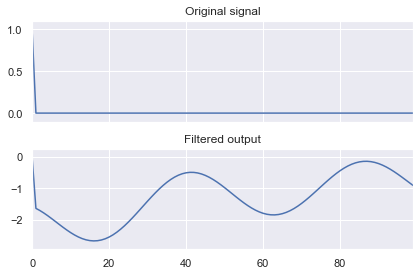

In [7]:
%matplotlib inline
sns.set()
plot_signal(sig, lds.simulate(K, sig))

### Теперь рассмотрим ситуацию с пространством состояний 

<ipython-input-4-89fcbdc26a96>:78: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


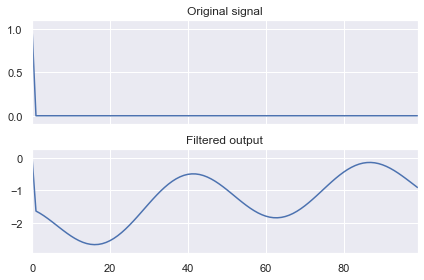

In [8]:
system = dlti(*lds.get_statespace(), dt=1)

_, y, _ = dlsim(system, sig)

%matplotlib inline
plot_signal(sig, y.T.ravel())



### Построим авторегрессионую модель ARMA и посмотрим как она будет вести с такими данными


### Импортируем необходимые библиотеки

<ipython-input-4-89fcbdc26a96>:78: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


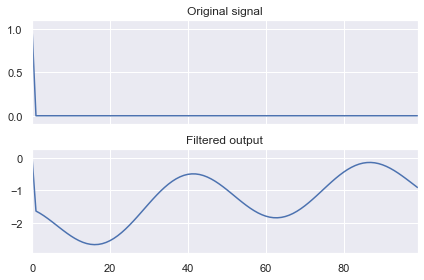

In [9]:
arma_process = sm.tsa.ArmaProcess(*lds.get_arma())

%matplotlib inline
plot_signal(sig, arma_process.impulse_response(K))

## Выводы
### По итогам проделанной работы, после моделирования и симуляции линейной модели, можно сделать вывод, что все три модели показывают идентичные результаты.



---

# Расчётно-графическая работа №2
---

### Согласно рекомендациям выберем длину интервалом возбуждения и релаксации


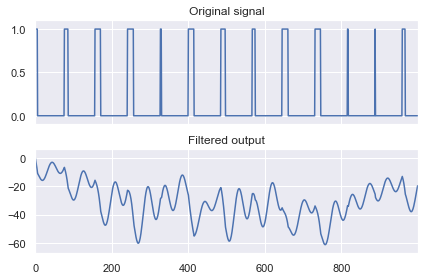

In [12]:
def make_signal(l: int, u0: float = 1.) -> np.array:
    signal = np.random.choice(np.arange(1, np.floor(l/4).astype(int)))
    return np.array([1.]*signal+[0.]*l)*u0

L = 70
sig = np.concatenate([make_signal(
    L, 1.) for i in range(150)])
_, y, _ =dlsim(system, sig)

%matplotlib inline
plot_signal(sig[:1000], y.T.ravel()[:1000])

### Теперь построим матрицу наблюдений с учётом интервалов релаксаций при помощи SVD, а также найдём размерность системы. 

In [13]:
Yhat = y.T.ravel()[sig==0.].reshape(-1, L).T[::-1]

# make function, which estimate dim
def estimate_dim(Yhat: np.ndarray, 
                 eps: float = 1e-4) -> int:
    
    U, sigma, V = svd(Yhat.T)
    
    sigma = np.vstack(
        (block_diag(*sigma), 
         np.zeros((U.shape[0]-sigma.shape[0],
                   sigma.shape[0])))
    )
    n = 0
    
    for dim in range(1, len(sigma)):
        Yl = np.dot(np.dot(U[:, dim:], sigma[dim:, dim:]), V[dim:, :]).T
        if norm(Yl, ord=np.inf) <= 2*eps:
            n=dim
            break
            
    return n

# find optim dim
N_estimated = estimate_dim(Yhat, eps=0.00001)

In [14]:
# solve the moore_penrose
def moore_penrose(u_t: np.ndarray, y_t: np.ndarray, lags: int = N_estimated):
    
    a = []
    y_rhs = y_t[lags:2*lags]
    
    for i in range(lags):
        a.append(np.append(y_t[i:lags+i][::-1], u_t[i:lags+i][::-1])[np.newaxis, ...])
    a = np.concatenate(a, axis=0)
    ab = pinv(a)@y_rhs
    a, b_estimated = ab[:lags], ab[lags:]
    a_estimated = np.eye(len(a), k=-1)
    a_estimated[:, -1] = np.array(a[::-1]).T
    
    return a_estimated, b_estimated[::-1].reshape(-1, 1)

    
def solve_svd(Yhat: np.ndarray, k: int = N_estimated, y_rhs: np.ndarray = None):
    
    U, sigma, V = svd(Yhat.T[:, -k:])
    y_rhs = Yhat.T[:, L-k-2] if y_rhs is None else y_rhs
    sigma = block_diag(*sigma)
    solution = np.dot(np.dot(np.dot(V.T, inv(sigma)), U[:, :k].T), y_rhs)
    
    return solution
        

display(Math(r'$ N_{approx} = %s $' % N_estimated))

<IPython.core.display.Math object>

### Оценочная размерность системы оказалась близка к фактической.
### Теперь необходимо будет решить СЛАУ для того, чтобы определить параметры системы. C помощью псевдообращения Мура-Пенроуза сможем получить векторы a & b.

In [15]:
a_estimated, b_estimated = moore_penrose(sig, y.T.ravel(), N_estimated)
system_reconstructed = dlti(a_estimated, b_estimated, np.array([0.]*(N_estimated-1)+[1.]).reshape(1, -1), [[0,]], dt=1)
display(Math(bmatrix(system_reconstructed.A, r'A_{approx}')))
display(Math(bmatrix(system.A, r'A_{true}')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Теперь убедимся, что модель и система совпадают. Для этого сравним отклик исходной системы и идентифицированной. 

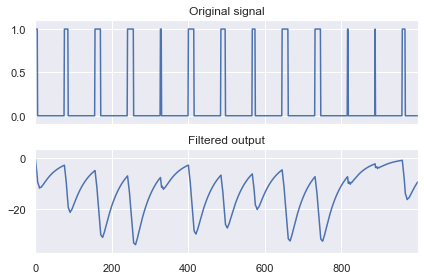

In [16]:
_, y_rec, _ = dlsim(system_reconstructed, sig)

%matplotlib inline
plot_signal(sig[:1000], y_rec.T.ravel()[:1000])

In [17]:
display(Math(r'$ || \epsilon_{1,2} ||_\infty = %s $' % str(norm(y_rec.T.ravel()-y.T.ravel(), ord=np.inf))))

<IPython.core.display.Math object>

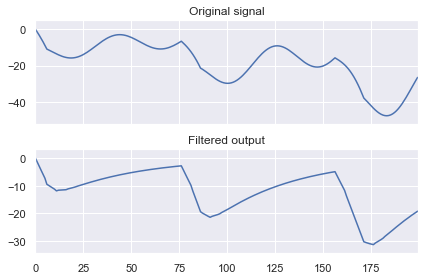

In [18]:
plot_signal(y[:200], y_rec.T.ravel()[:200])

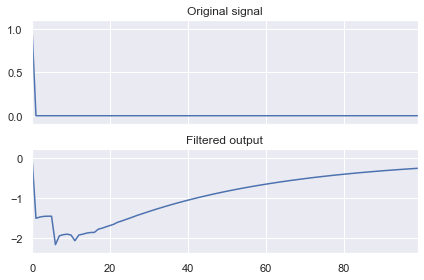

In [19]:
sig_unit = unit_impulse(K)
_, y_rec, _ = dlsim(system_reconstructed, sig_unit)

%matplotlib inline
plot_signal(sig_unit, y_rec.T.ravel())

### Можно видеть, что система хорошо индентифицируема. 

---
# Расчётно-исследовательская работа №3
---

### Необходимо сформировать погрешности со значениями:  
$\varepsilon_1$ = 0.0001;  
$\varepsilon_2$ = 0.001;  
$\varepsilon_3$ = 0.01;  
$\varepsilon_4$ = 0,1.

### Вычислим сигналы, которые содержат различные погрешности

### Для $\varepsilon_1$ = 0.0001:

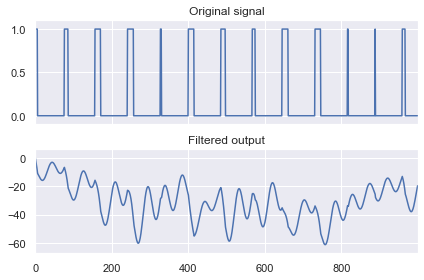

In [20]:
eps4 = 1e-4*np.random.uniform(size=(len(sig), 1))
y_eps = y + eps4


%matplotlib inline
plot_signal(sig[:1000], y_eps.T.ravel()[:1000])

Найдём y и оценочную размерность

In [25]:
Yhat = y_eps.T.ravel()[sig==0.].reshape(-1, L).T[::-1]

N_estimated = estimate_dim(Yhat, eps=1e-4)
display(Math(r'$ N_{approx} = %s $' % N_estimated))

<IPython.core.display.Math object>

Найдём вектора a & b при помощи псевдообращения Мура-Пенроуза

In [28]:
a_estimated, b_estimated = moore_penrose(sig, y_eps.T.ravel(), N_estimated)
system_reconstructed = dlti(a_estimated, b_estimated, np.array([0.]*(N_estimated-1)+[1.]).reshape(1, -1), [[0,]], dt=1)

Отобразим восстановленную систему

In [30]:
display(Math(bmatrix(system_reconstructed.A, r'A_{approx}')))

display(Math(bmatrix(system.A, r'A_{true}')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Сравним импульсные переходные функции системы и полученной модели

In [31]:
_, y_rec, _ = dlsim(system_reconstructed, sig)

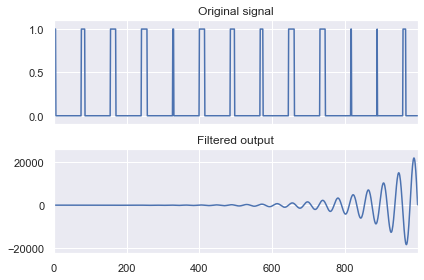

In [32]:
%matplotlib inline
plot_signal(sig[:1000], y_rec.T.ravel()[:1000])

Найдём бесконечную норму для эпсилона.

In [33]:
display(Math(r'$ || \epsilon_{1,2} ||_\infty = %s $' % str(norm(y_rec.T.ravel()-y_eps.T.ravel(), ord=np.inf))))

<IPython.core.display.Math object>

Сравним сигналы

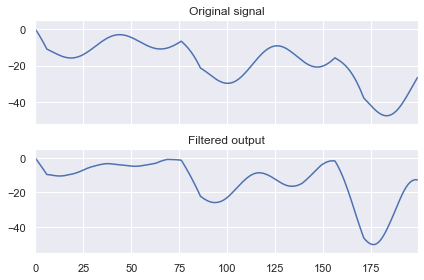

In [34]:
plot_signal(y[:200], y_rec.T.ravel()[:200])


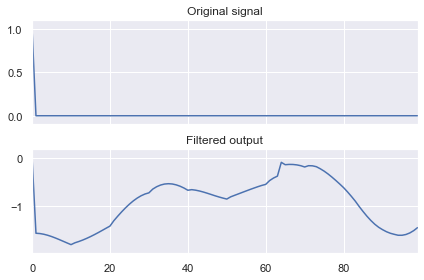

In [37]:
sig_unit = unit_impulse(K)
_, y_rec, _ = dlsim(system_reconstructed, sig_unit)

%matplotlib inline
plot_signal(sig_unit, y_rec.T.ravel())

### Сделаем то же самое для $\varepsilon_2$ = 0.001:

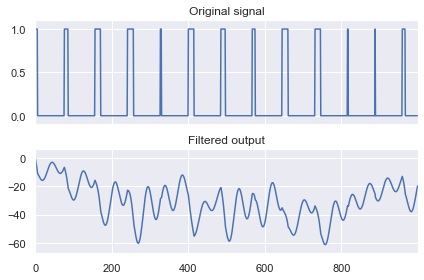


Оценочная размерность


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Сравним импульсные переходные функции системы и полученной модели


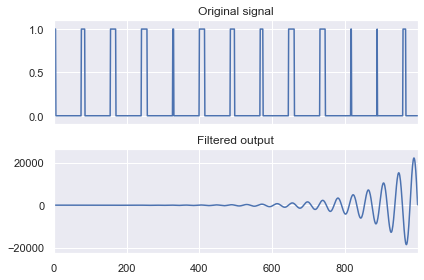

<IPython.core.display.Math object>

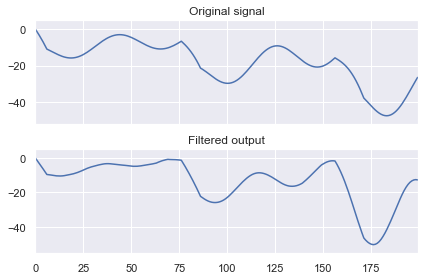


Сигнал восстановленной системы


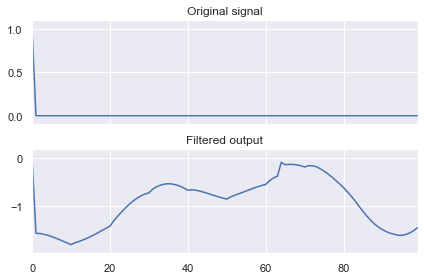

In [55]:
eps3 = 1e-3*np.random.uniform(size=(len(sig), 1))
y_eps = y + eps3
%matplotlib inline
plot_signal(sig[:1000], y_eps.T.ravel()[:1000])

Yhat = y_eps.T.ravel()[sig==0.].reshape(-1, L).T[::-1]
N_estimated = estimate_dim(Yhat, eps=1e-3)

print("\nОценочная размерность")
display(Math(r'$ N_{approx} = %s $' % N_estimated))

a_estimated, b_estimated = moore_penrose(sig, y_eps.T.ravel(), N_estimated)
system_reconstructed = dlti(a_estimated, b_estimated, np.array([0.]*(N_estimated-1)+[1.]).reshape(1, -1), [[0,]], dt=1)
display(Math(bmatrix(system_reconstructed.A, r'A_{approx}')))
display(Math(bmatrix(system.A, r'A_{true}')))

print("\nСравним импульсные переходные функции системы и полученной модели")
_, y_rec, _ = dlsim(system_reconstructed, sig)
%matplotlib inline
plot_signal(sig[:1000], y_rec.T.ravel()[:1000])
display(Math(r'$ || \epsilon_{1,2} ||_\infty = %s $' % str(norm(y_rec.T.ravel()-y_eps.T.ravel(), ord=np.inf))))
plot_signal(y[:200], y_rec.T.ravel()[:200])

print("\nСигнал восстановленной системы")
sig_unit = unit_impulse(K)
_, y_rec, _ = dlsim(system_reconstructed, sig_unit)
%matplotlib inline
plot_signal(sig_unit, y_rec.T.ravel())

### Для $\varepsilon_3$ = 0.01:

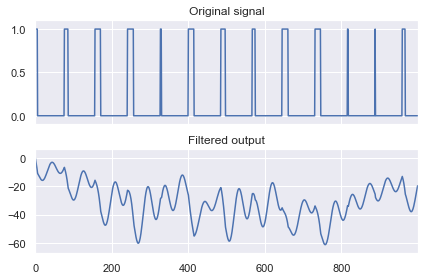


Оценочная размерность


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Сравним импульсные переходные функции системы и полученной модели


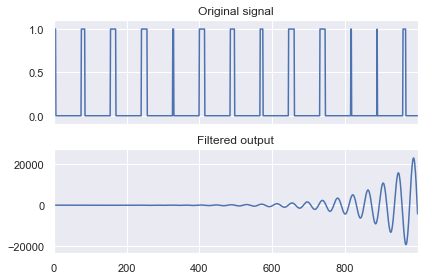

<IPython.core.display.Math object>

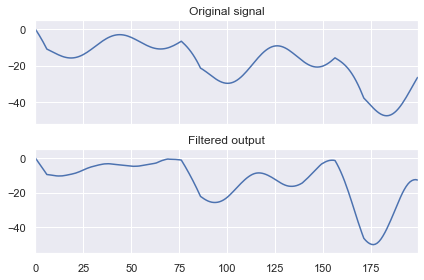


Сигнал восстановленной системы


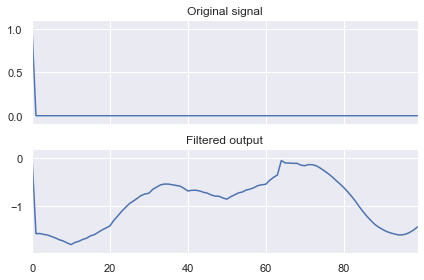

In [56]:
eps2 = 1e-2*np.random.uniform(size=(len(sig), 1))
y_eps = y + eps2
%matplotlib inline
plot_signal(sig[:1000], y_eps.T.ravel()[:1000])

Yhat = y_eps.T.ravel()[sig==0.].reshape(-1, L).T[::-1]
N_estimated = estimate_dim(Yhat, eps=1e-2)

print("\nОценочная размерность")
display(Math(r'$ N_{approx} = %s $' % N_estimated))

a_estimated, b_estimated = moore_penrose(sig, y_eps.T.ravel(), N_estimated)
system_reconstructed = dlti(a_estimated, b_estimated, np.array([0.]*(N_estimated-1)+[1.]).reshape(1, -1), [[0,]], dt=1)
display(Math(bmatrix(system_reconstructed.A, r'A_{approx}')))
display(Math(bmatrix(system.A, r'A_{true}')))

print("\nСравним импульсные переходные функции системы и полученной модели")
_, y_rec, _ = dlsim(system_reconstructed, sig)
%matplotlib inline
plot_signal(sig[:1000], y_rec.T.ravel()[:1000])
display(Math(r'$ || \epsilon_{1,2} ||_\infty = %s $' % str(norm(y_rec.T.ravel()-y_eps.T.ravel(), ord=np.inf))))
plot_signal(y[:200], y_rec.T.ravel()[:200])

print("\nСигнал восстановленной системы")
sig_unit = unit_impulse(K)
_, y_rec, _ = dlsim(system_reconstructed, sig_unit)
%matplotlib inline
plot_signal(sig_unit, y_rec.T.ravel())

### И последняя погрешность, $\varepsilon_4$ = 0.1:

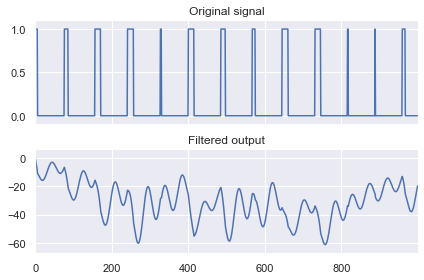


Оценочная размерность


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Сравним импульсные переходные функции системы и полученной модели


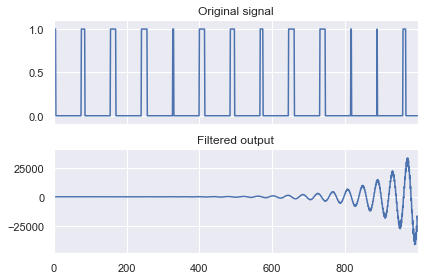

<IPython.core.display.Math object>

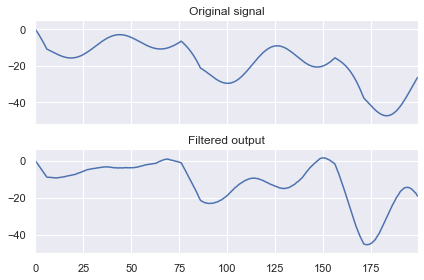


Сигнал восстановленной системы


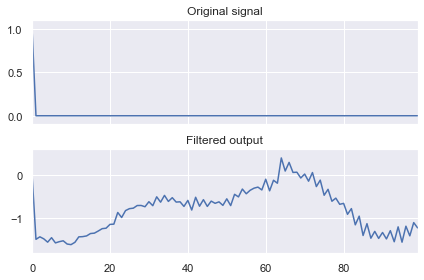

In [57]:
eps1 = 1e-1*np.random.uniform(size=(len(sig), 1))
y_eps = y + eps1
%matplotlib inline
plot_signal(sig[:1000], y_eps.T.ravel()[:1000])

Yhat = y_eps.T.ravel()[sig==0.].reshape(-1, L).T[::-1]
N_estimated = estimate_dim(Yhat, eps=1e-1)

print("\nОценочная размерность")
display(Math(r'$ N_{approx} = %s $' % N_estimated))

a_estimated, b_estimated = moore_penrose(sig, y_eps.T.ravel(), N_estimated)
system_reconstructed = dlti(a_estimated, b_estimated, np.array([0.]*(N_estimated-1)+[1.]).reshape(1, -1), [[0,]], dt=1)
display(Math(bmatrix(system_reconstructed.A, r'A_{approx}')))
display(Math(bmatrix(system.A, r'A_{true}')))

print("\nСравним импульсные переходные функции системы и полученной модели")
_, y_rec, _ = dlsim(system_reconstructed, sig)
%matplotlib inline
plot_signal(sig[:1000], y_rec.T.ravel()[:1000])
display(Math(r'$ || \epsilon_{1,2} ||_\infty = %s $' % str(norm(y_rec.T.ravel()-y_eps.T.ravel(), ord=np.inf))))
plot_signal(y[:200], y_rec.T.ravel()[:200])

print("\nСигнал восстановленной системы")
sig_unit = unit_impulse(K)
_, y_rec, _ = dlsim(system_reconstructed, sig_unit)
%matplotlib inline
plot_signal(sig_unit, y_rec.T.ravel())

### Вывод: как и ожидалось, при увеличении вводимой погрешности качество восстановленного сигнала падает. 